In [ ]:
library(tidyverse)
library(nowcastLSTM)
initialize_session()

In [2]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [ ]:
# full data read
metadata <- read_csv("../data/meta_data.csv")
data <- read_csv("../data/data_tf.csv") %>%
  arrange(date)

target_variable <- "gdpc1"

# which lags to assess
lags <- -2:2

# dates for training and test
# test set is shorter in this example notebook than in the paper to save runtime. Set test_start_date to "2002-03-01" and test_end_date to "2022-09-01" for results of the paper.
train_start_date <- "1947-01-01"
test_start_date <- "2005-03-01"
test_end_date <- "2010-03-01"

# test datasets
test <- data %>%
    dplyr::filter(date >= train_start_date, date <= test_end_date) %>% # let test set data begin from training begin, data lag/time series for test sets can go back into the training data
    data.frame()

# replace any infinites with NA
for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
tail(data)

date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,⋯,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-08-01,0.001915508,NA,0.0011819650,0.002335260,0.18968692,0.006719933,0.05714286,0.09513435,-0.0006862216,⋯,-0.012295082,0.005672678,0.005504572,0.002682399,-0.08486647,-0.002056898,0.009037228,NA,-0.013707165,NA
2022-09-01,0.001761255,0.008011552,0.0038596847,0.002037679,-0.13467492,-0.001672780,-0.05405405,-0.02851459,0.0038251759,⋯,-0.010373444,0.005758545,0.004644000,0.003443036,0.01426719,0.002560770,0.002484690,0.005911377,-0.009475679,0.002056349
2022-10-01,0.001856197,NA,0.0043839992,0.007361543,0.08228980,0.013065747,0.05714286,-0.02116041,-0.0006249231,⋯,-0.004192872,0.002715462,0.002616225,0.003729239,-0.03324808,-0.001788585,0.002912884,NA,-0.003826531,NA
2022-11-01,0.001715758,NA,0.0009628869,-0.020892196,0.05785124,-0.005824232,0.00000000,-0.00488145,-0.0021948039,⋯,-0.006315789,0.001986837,0.001680901,0.001043196,-0.10648148,-0.003270767,NA,NA,-0.002560819,NA
2022-12-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Training the model
The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 1999-12-01, right before the beginning of the prediction period.

# Testing the model on artificial data vintages

In [5]:
# dates in the test set
dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by="month") %>% 
      .[(substr(., 6, 7) %in% c("03", "06", "09", "12"))]

In [6]:
# dataframe for predictions
pred_dict <- data.frame(date = dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}

In [7]:
# looping through test dates
for (date in as.character(dates)) {
    # training the model
    train <- test %>%
            dplyr::filter(date <= seq(as.Date(!!date), by="-3 months", length=2)[2]) # data as it would have appeared at beginning of prediction period
    
    model <- LSTM(
        data = train,
        target_variable = target_variable,
        n_timesteps = 6,
        fill_na_func = "mean",
        fill_ragged_edges_func = "mean",
        n_models = 10,
        train_episodes = 100,
        batch_size = 50,
        decay = 0.98,
        n_hidden = 10,
        n_layers = 1,
        dropout = 0.0,
        criterion = "torch.nn.MSELoss()",
        optimizer = "torch.optim.Adam",
        optimizer_parameters = list("lr"=1e-2, "weight_decay"=0.0)
    )
    
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, test, date, lag)
    predictions <- predict(model, lagged_data)
    prediction <- predictions %>%
      dplyr::filter(date == !!date) %>%
      select(predictions) %>%
      pull()
    pred_dict[pred_dict$date == date, as.character(lag)] <- prediction
  }
}

# Assess and visualize model performance

In [8]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    select(!!target_variable) %>%
    filter(!is.na(!!sym(target_variable))) %>%
    pull()

In [9]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage,RMSE
<dbl>,<dbl>
-2,0.0072
-1,0.0051
0,0.0044
1,0.0042
2,0.0043


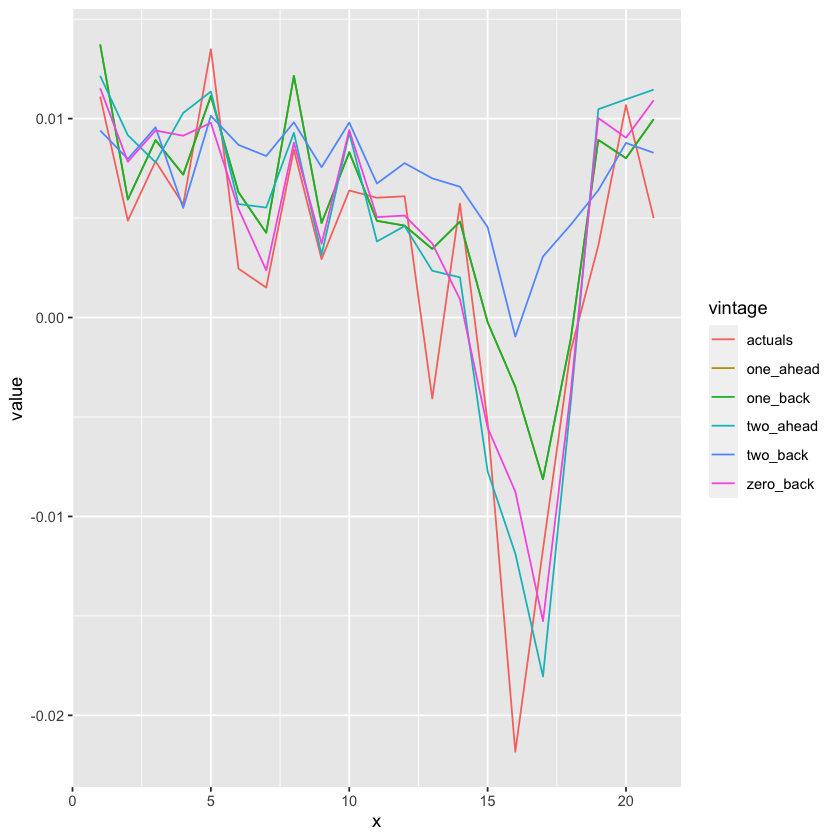

In [10]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    dplyr::mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Hyperparameter tuning
To hyperparameter tune, you would wrap everything from "Training the model" to "Assess and visualize performance" in a loop and save the performance metrics to a csv. In pseudo code:

```
for hyperparam1 in [option1, option2]:
    for hyperparam2 in [option1, option2]:
    ...
        model = your_model(hyperparam1 = hyperparam1 ...)
        ...
        results = results.append(tmp_results)
results.to_csv("results.csv", index=False)
```

In v0.2.0 of the _nowcast\_lstm_ library, you can now perform hyperparameter tuning from within the library with the `hyperparameter_tuning` function, no need to set up your own loops. See the [repository's](https://github.com/dhopp1/nowcast_lstm) example file for more information. Variable selection can also be performed from within the library via the `variable_selection` function.

## Below is a list of recommended hyperparameter values to use for grid search with the LSTM if results are not very good with default parameters
- *n_timesteps* (for a quarterly target variable): **[3, 6, 12]**
- *n_timesteps* (for a yearly target variable): **[12, 24]**
- *fill_ragged_edges_func*: **[np.nanmean, "ARMA"]** (warning: ARMA can take a very long time to estimate, the mean is usually capable of getting good predictions and is much faster)
- *n\_models*: **[10]** (this can usually be kept to 10 as a good balance between consistent predictions and estimation time)
- *train_episodes*: **[50, 100, 200]**
- *batch_size*: **[50, 100, 200]**
- *decay*: **[0.98]** (this is fine to keep at the default value of 0.98)
- *n_hidden*: **[10, 20, 40]**
- *n_layers*: **[1, 2, 4]**
- *dropout*: **[0.0]** (this is fine to keep at the default value of 0.0, using `weight_decay` instead for additional regularization if necessary)
- *criterion*: **[torch.nn.L1Loss(), torch.nn.MSELoss()]**
- *optimizer*: **[torch.optim.Adam]** (this is usually fine to keep at the default of Adam)
- *lr*: **[1e-2]** (this is fine to keep at the default value because of the `decay` parameter)
- *weight_decay*: **[0.0]** (this is usually fine to keep at 0.0, neural networks already perform a sort of regularization)

**Note**: `lr` and `weight_decay` should be passed to the `optimizer_parameters` function as a dictionary, e.g. `optimizer_parameters = {"lr": 1e-2, "weight_decay": 0.0}`

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [11]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test

# the date we want predicted must be in the date, if it's not there it must be added
desired_date <- "2010-06-01"
months_to_add <- seq(max(new_data$date), as.Date(desired_date), by="month") %>% as.character()

for (value in months_to_add[2:length(months_to_add)]) {
    new_data[nrow(new_data) + 1, "date"] <- value
}

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data %>% tail()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,⋯,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
757,2010-01-01,1.540975e-05,NA,0.0006487322,0.127685024,-0.01988636,-8.379759e-05,-0.01010101,0.05679862,0.010900832,⋯,0.0120578778,-0.0011227765,0.0014678326,2.186252e-03,-0.04216867,0.012824908,0.001697060,NA,0.008354219,NA
758,2010-02-01,-7.088374e-04,NA,-0.0009517766,-0.003126795,-0.02608696,2.288733e-03,0.00000000,-0.01628664,0.003535007,⋯,-0.0007942812,0.0004441765,0.0008731718,-3.146369e-05,0.02201258,0.005553038,0.006594576,NA,-0.003314002,NA
759,2010-03-01,1.395550e-03,0.005000535,0.0003313681,0.009409809,0.13392857,2.169620e-02,0.01020408,0.05298013,0.007105439,⋯,0.0039745628,0.0002355809,0.0014955601,1.415911e-03,0.05692308,0.009229304,0.004449005,-0.01190992,0.007481297,0.005756856
760,2010-04-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
761,2010-05-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
762,2010-06-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [12]:
# training the model
model <- LSTM(
    data = new_data,
    target_variable = target_variable,
    n_timesteps = 6,
    fill_na_func = "mean",
    fill_ragged_edges_func = "mean",
    n_models = 10,
    train_episodes = 100,
    batch_size = 50,
    decay = 0.98,
    n_hidden = 10,
    n_layers = 1,
    dropout = 0.0,
    criterion = "torch.nn.MSELoss()",
    optimizer = "torch.optim.Adam",
    optimizer_parameters = list("lr"=1e-2, "weight_decay"=0.0)
)

In [13]:
predictions <- predict(model, new_data)
prediction <- predictions %>%
    dplyr::filter(date == "2010-06-01") %>%
    select(predictions) %>%
    pull()
prediction

[1] 0.008333331